# Bank marketing campaigns dataset analysis - Opening a Term Deposit

It is a dataset that describing Portugal bank marketing campaigns results.
Conducted campaigns were based mostly on direct phone calls, offering bank client to place a term deposit.
If after all marking afforts client had agreed to place deposit - target variable marked 'yes', otherwise 'no'

## Dataset

### Bank's Client Data:

1. age (numeric)

2. job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")

3. marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)

4. education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")

5. default: has credit in default? (categorical: "no","yes","unknown")

6. housing: has housing loan? (categorical: "no","yes","unknown")

7. loan: has personal loan? (categorical: "no","yes","unknown")

### Info related with the last contact of the current campaign:

8. contact: contact communication type (categorical: "cellular","telephone")

9. month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")

10. dayofweek: last contact day of the week (categorical: "mon","tue","wed","thu","fri")

11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### Other attributes:

12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14. previous: number of contacts performed before this campaign and for this client (numeric)

15. poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

### Social and economic context attributes

16. emp.var.rate: employment variation rate - quarterly indicator (numeric)

17. cons.price.idx: consumer price index - monthly indicator (numeric)

18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)

19. euribor3m: euribor 3 month rate - daily indicator (numeric)

20. nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):

21. y: has the client subscribed a term deposit? (binary: "yes","no")


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from pandas import get_dummies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score

%matplotlib inline


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Loading Data

In [2]:
# The code was removed by Watson Studio for sharing.

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Defining aux functions

In [3]:
def replace_outliers(df, features):
    '''Replace outliers with value of the outlier step (1.7 times interquartile)
    
    INPUT
    -----
    df: Panda Dataframe
    features: list
              List of columns to replace outliers
    
    RETURNS
    -------
    df: Panda Dataframe
        Dataframe with no outlier
    '''
    for col in features:
        print("[INFO] COLUMN: ", col)
        # 1st quartile
        Q1 = np.percentile(df[col], 25)
        # 3d quartile
        Q3 = np.percentile(df[col], 75)
        # Interquartile
        IQR = Q3 - Q1
        print("[INFO] VALUE OF INTERQUARTILE: ", IQR)

        # Outlier step
        outlier_step = 1.5 * IQR
        print("[INFO] VALUE TO REPLACE: >", outlier_step)

        df[col].loc[df[col] > outlier_step]  = outlier_step
    return df

In [4]:
def etl_df(df):
    """Prepare the dataframe to be used for predictions following the
    follow steps:
    1 - Label encoding
    2 - Changing pdays to binary (now it is previously contacted or not)
    3 - One-hot-enconding the columns 'job'
    4 - Removing outlier
    
    Parameters
    ----------
    df: dataframe
        The dataframe resulted from etl.
    
    Returns
    -------
    df: dataframe
        The dataframe with its new features and ready for training
    """
    new_df = df
    label_encoder = LabelEncoder()

    column_list = ['marital', 'education', 'default', 'housing', 'loan', 'month',
                   'day_of_week', 'poutcome', 'contact', 'y']
    
    
    for column in column_list:
        new_df[column] = label_encoder.fit_transform(df[column])
    
    new_df = get_dummies(new_df, prefix=['job'], columns=['job'], drop_first=True)
    
    non_categorical_cols = ['age', 'duration', 'campaign', 'pdays', 'emp.var.rate',
                        'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
    
    new_df = replace_outliers(new_df, non_categorical_cols)
    
    return new_df

In [5]:
def prepare_for_training(df):
    """Prepara the dataframe to be trained by a machine learning algorithm
    
    Parameters:
    -----------
    df: dataframe
        The dataframe to be prepared
    
    Returns:
    --------
    X_train: array
        The train input
    X_test: array
        The test input
    y_train: array
        The train target (labels)
    y_test: array
        The test target (labels)
    """
    y = df['y']
    X = df.drop('y',axis=1)
    
    scaler = MinMaxScaler()
    df_array = X
    scaled_data = scaler.fit_transform(df_array)
    
    return train_test_split(scaled_data, y, test_size=0.3, random_state=1, stratify=y)

Let's apply the pipeline so far on our data.

# 6.2 Model Definition
We will use Gradient Boosting. We can see it is the one that misses less ONES (open acc).

Let's take a look at the model without re-engineering

In [6]:
df_onehot = etl_df(df)
X_train, X_test, y_train, y_test = prepare_for_training(df_onehot)
model = AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(criterion='entropy'),
                   learning_rate=1, n_estimators=2, random_state=8)
model.fit(X_train, y_train)

[INFO] COLUMN:  age
[INFO] VALUE OF INTERQUARTILE:  15.0
[INFO] VALUE TO REPLACE: > 22.5


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


[INFO] COLUMN:  duration
[INFO] VALUE OF INTERQUARTILE:  217.0
[INFO] VALUE TO REPLACE: > 325.5
[INFO] COLUMN:  campaign
[INFO] VALUE OF INTERQUARTILE:  2.0
[INFO] VALUE TO REPLACE: > 3.0
[INFO] COLUMN:  pdays
[INFO] VALUE OF INTERQUARTILE:  0.0
[INFO] VALUE TO REPLACE: > 0.0
[INFO] COLUMN:  emp.var.rate
[INFO] VALUE OF INTERQUARTILE:  3.2
[INFO] VALUE TO REPLACE: > 4.800000000000001
[INFO] COLUMN:  cons.price.idx
[INFO] VALUE OF INTERQUARTILE:  0.9189999999999969
[INFO] VALUE TO REPLACE: > 1.3784999999999954
[INFO] COLUMN:  cons.conf.idx
[INFO] VALUE OF INTERQUARTILE:  6.300000000000004
[INFO] VALUE TO REPLACE: > 9.450000000000006
[INFO] COLUMN:  euribor3m
[INFO] VALUE OF INTERQUARTILE:  3.617
[INFO] VALUE TO REPLACE: > 5.4254999999999995
[INFO] COLUMN:  nr.employed
[INFO] VALUE OF INTERQUARTILE:  129.0
[INFO] VALUE TO REPLACE: > 193.5


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=2, random_state=8)

In [7]:
prediction = model.predict(X_test)
prediction

array([0, 0, 0, ..., 0, 0, 0])

In [8]:
model_score = recall_score(y_test, prediction)
print("Recall: ", model_score)

Recall:  0.4525862068965517


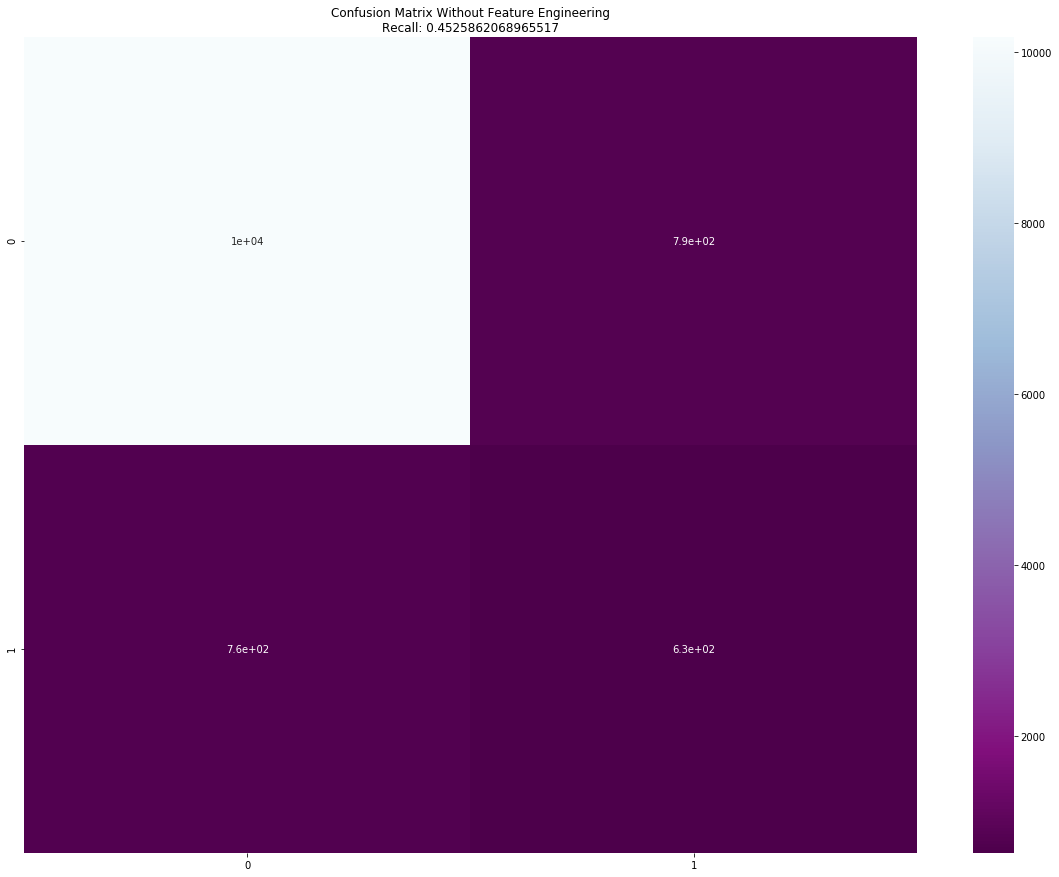

In [9]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, prediction)
plt.figure(figsize=(20, 15))
plt.title('Confusion Matrix Without Feature Engineering\nRecall: {}'.format(model_score))
sns.heatmap(conf_matrix, annot=True, cmap='BuPu_r')

# 7. Feature re-engineering
In this chapter, we will reduce the dimensions of our dataset and repeat step 4.

## 7.1. Dropping columns with high corr with eachother

In [10]:
df_eng = df_onehot.drop(['emp.var.rate', 'euribor3m', 'cons.price.idx'], axis=1)
df_eng.shape

(41188, 28)

Let's see how it affected our predictions

In [11]:
X_train, X_test, y_train, y_test = prepare_for_training(df_eng)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [12]:
model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=2, random_state=8)

In [13]:
prediction = model.predict(X_test)
prediction

array([0, 1, 0, ..., 0, 0, 0])

In [14]:
total_1 = np.count_nonzero(prediction == 1)
total_1

1478

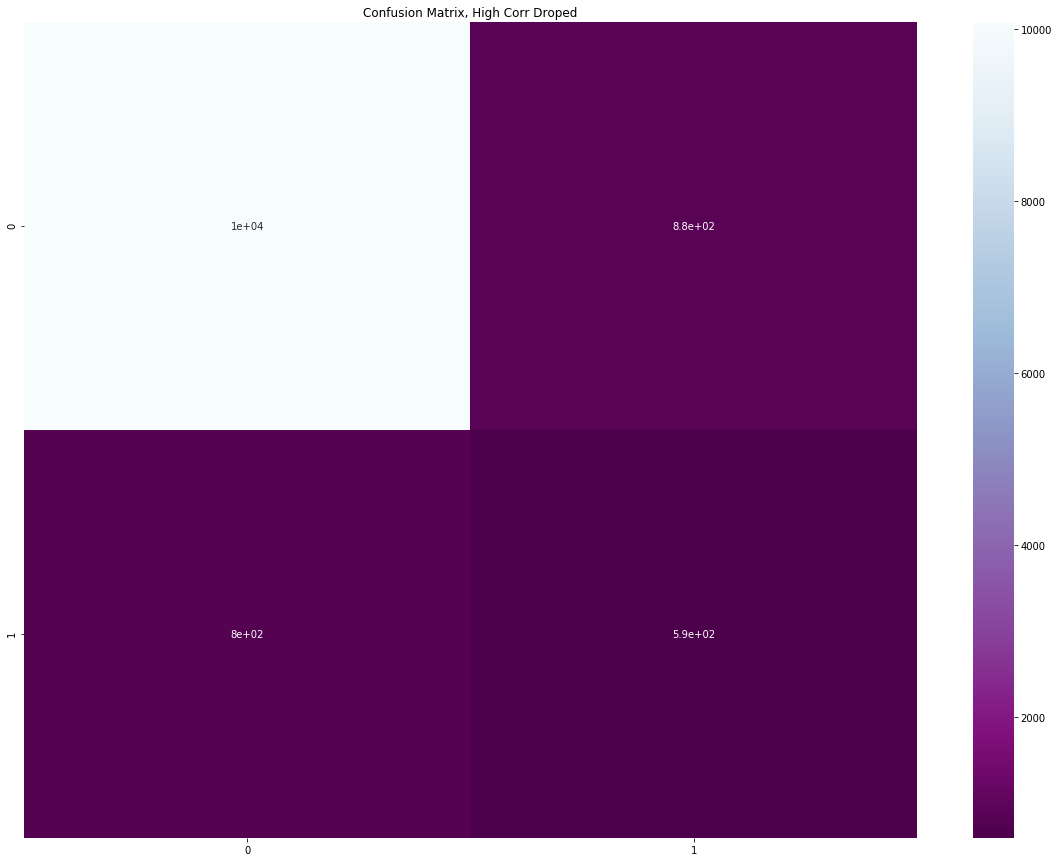

In [15]:
conf_matrix = confusion_matrix(y_test, prediction)
plt.figure(figsize=(20,15))
plt.title('Confusion Matrix, High Corr Droped')
sns.heatmap(conf_matrix, annot=True, cmap='BuPu_r')

In [16]:
model_score = recall_score(y_test, prediction)
model_score

0.4267241379310345

We have no improvements

## 7.2. Removing low corr
Let's remove columns that has no/low corr with y

In [17]:
df_eng_2 = df_onehot.drop(['education'], axis=1)
df_eng_2.shape

(41188, 30)

In [18]:
X_train, X_test, y_train, y_test = prepare_for_training(df_eng_2)
model.fit(X_train, y_train)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=2, random_state=8)

In [19]:
prediction = model.predict(X_test)
prediction

array([0, 0, 0, ..., 0, 0, 0])

Text(159.0, 0.5, 'Real')

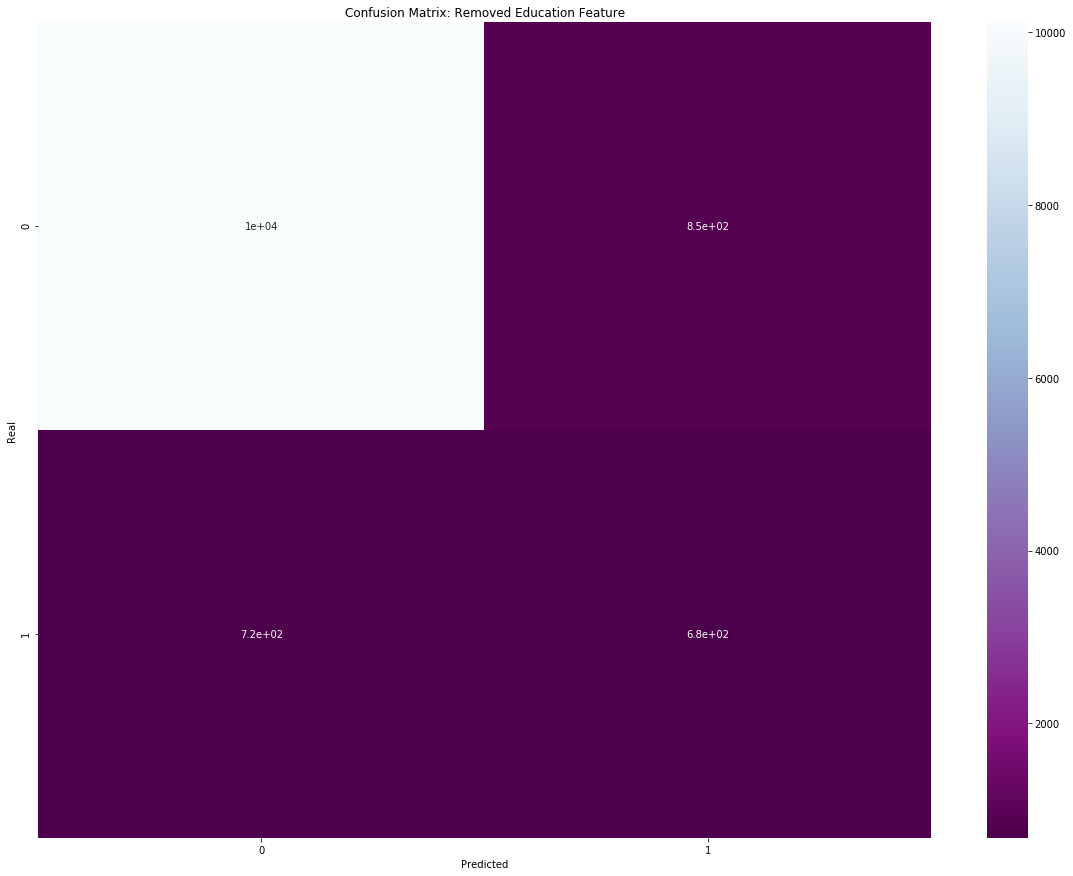

In [20]:
conf_matrix = confusion_matrix(y_test, prediction)
plt.figure(figsize=(20,15))
plt.title("Confusion Matrix: Removed Education Feature")
sns.heatmap(conf_matrix, annot=True, cmap='BuPu_r')
plt.xlabel('Predicted')
plt.ylabel('Real')

In [21]:
model_score = recall_score(y_test, prediction)
model_score

0.48563218390804597

## 7.3. Mixing features to remove

Let's remove columns from 7.1 and 7.2

In [22]:
df_eng_3 = df.drop(['education', 'emp.var.rate', 'cons.price.idx', 'day_of_week', 'month', 'marital', 'contact', 'campaign', 'job'], axis=1)
df_eng_3.shape

(41188, 12)

In [23]:
df_eng_3.head(5)

,age,default,housing,loan,duration,pdays,previous,poutcome,cons.conf.idx,euribor3m,nr.employed,y
0,56,0,0,0,261,999,0,1,-36.4,4.857,5191.0,0
1,57,1,0,0,149,999,0,1,-36.4,4.857,5191.0,0
2,37,0,2,0,226,999,0,1,-36.4,4.857,5191.0,0
3,40,0,0,0,151,999,0,1,-36.4,4.857,5191.0,0
4,56,0,0,2,307,999,0,1,-36.4,4.857,5191.0,0


In [24]:
label_encoder = LabelEncoder()
column_list = ['default', 'housing', 'loan', 'poutcome', 'y']
for column in column_list:
        df_eng_3[column] = label_encoder.fit_transform(df_eng_3[column])

df_eng_3.head(5)

,age,default,housing,loan,duration,pdays,previous,poutcome,cons.conf.idx,euribor3m,nr.employed,y
0,56,0,0,0,261,999,0,1,-36.4,4.857,5191.0,0
1,57,1,0,0,149,999,0,1,-36.4,4.857,5191.0,0
2,37,0,2,0,226,999,0,1,-36.4,4.857,5191.0,0
3,40,0,0,0,151,999,0,1,-36.4,4.857,5191.0,0
4,56,0,0,2,307,999,0,1,-36.4,4.857,5191.0,0


In [25]:
X_train, X_test, y_train, y_test = prepare_for_training(df_eng_3)
model.fit(X_train, y_train)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=2, random_state=8)

In [26]:
prediction = model.predict(X_test)
prediction

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
model_metric = recall_score(y_test, prediction)
model_metric

0.5251436781609196

Text(159.0, 0.5, 'Real')

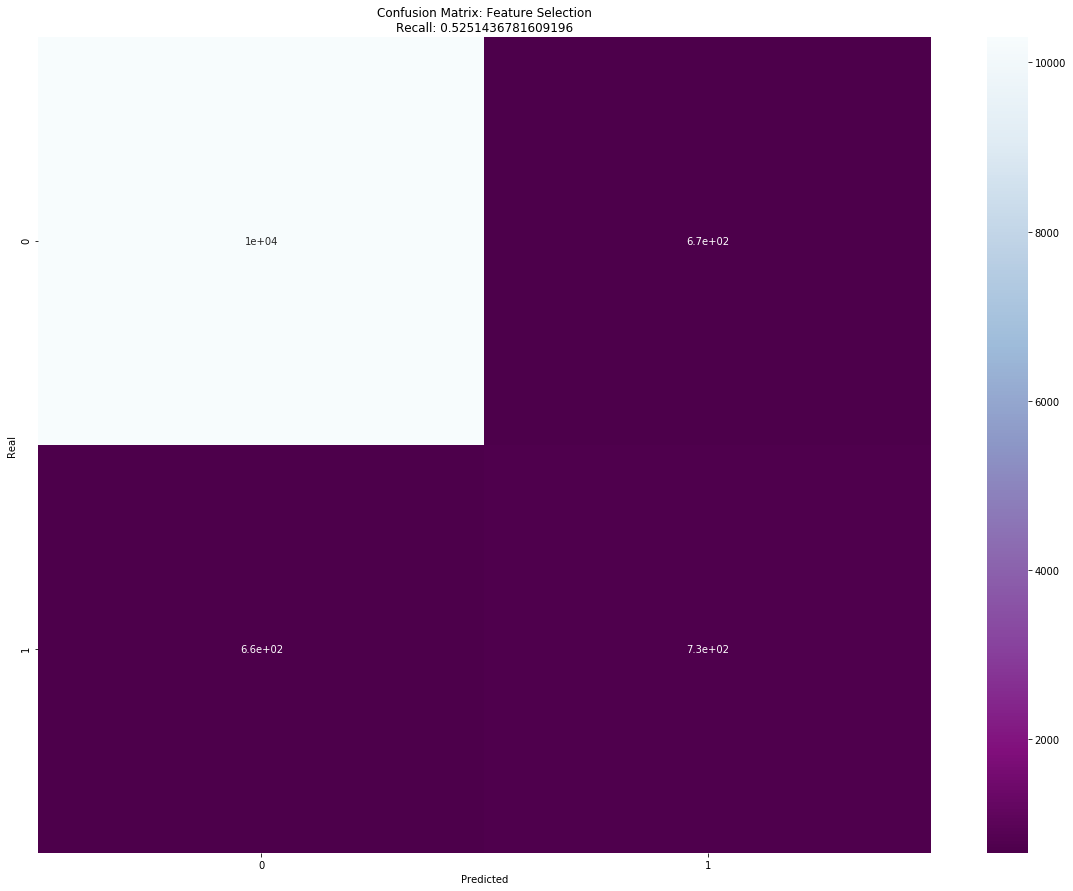

In [28]:
conf_matrix = confusion_matrix(y_test, prediction)
plt.figure(figsize=(20,15))
plt.title("Confusion Matrix: Feature Selection\nRecall: {}".format(model_metric))
sns.heatmap(conf_matrix, annot=True, cmap='BuPu_r')
plt.xlabel('Predicted')
plt.ylabel('Real')

In [29]:
model_final = model

Wow! Now we have an improvement! Nice.

It was not a good idea. Let's use our first model and apply PCA

In [30]:
from sklearn.decomposition import PCA

Let's see the importance per component

In [31]:
pca = PCA(n_components=11)
data_pca = pca.fit(X_train)
data_pca.explained_variance_ratio_

array([0.32686759, 0.29111834, 0.16734492, 0.06939196, 0.05227081,
       0.04296088, 0.02098956, 0.0196829 , 0.00468783, 0.00364554,
       0.00103966])

We will use our first 8 components

In [32]:
pca = PCA(n_components=8)
data_pca = pca.fit_transform(X_train)
data_pca.shape

(28831, 8)

In [33]:
model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=2, random_state=8)

In [34]:
prediction = model.predict(X_test)
prediction

array([0, 0, 0, ..., 0, 0, 0])

Text(159.0, 0.5, 'Real')

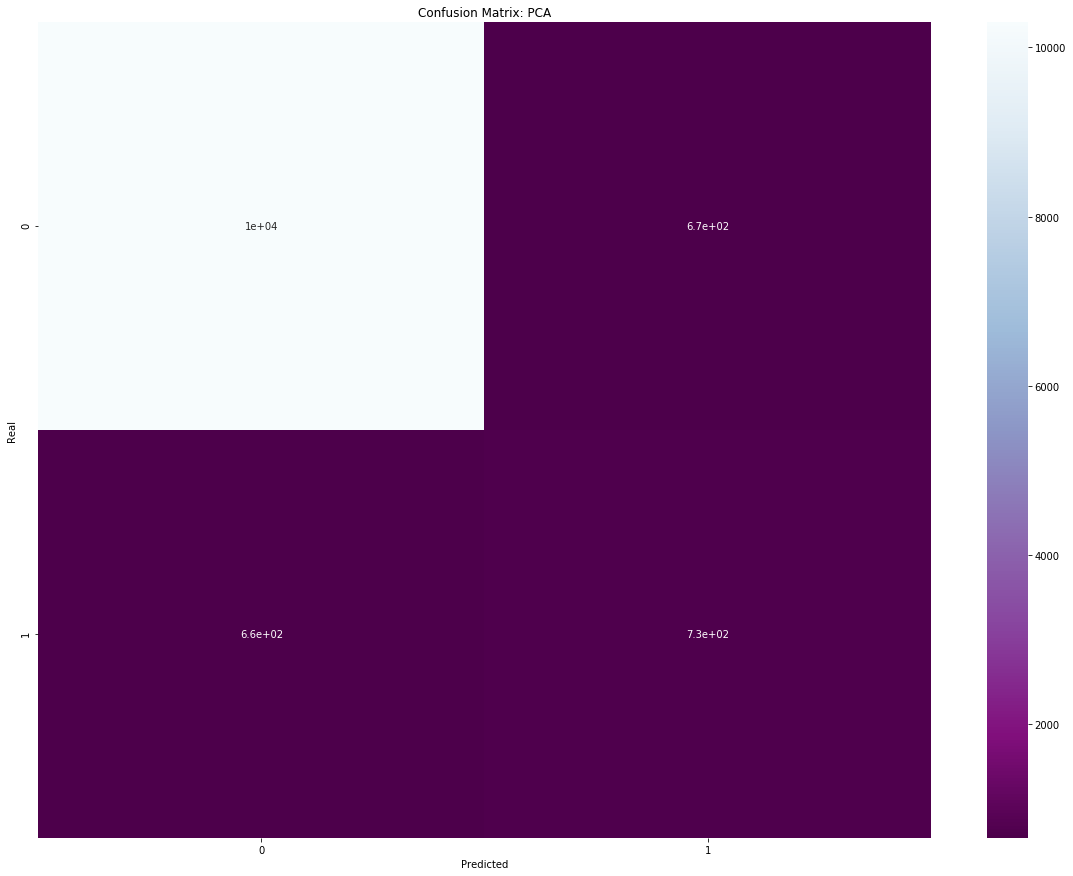

In [35]:
conf_matrix = confusion_matrix(y_test, prediction)
plt.figure(figsize=(20,15))
plt.title('Confusion Matrix: PCA')
sns.heatmap(conf_matrix, annot=True, cmap='BuPu_r')
plt.xlabel('Predicted')
plt.ylabel('Real')

In [36]:
model_score = recall_score(y_test, prediction)
model_score

0.5251436781609196

PCA also is not helping. We will use the data with the engieering from 5.3 for this work.

Next, we will save our model on the cloud using pickle files. The next cell is hidden because it has auth keys.

In [39]:
# The code was removed by Watson Studio for sharing.

{'file_name': 'model_v1_2.sav',
 'message': 'File saved to project storage.',
 'bucket_name': 'advanceddatasciencecapstone-donotdelete-pr-n88cysxgvre2bb',
 'asset_id': '7b463c96-c43a-42c4-8f1c-cbbcbc7c87b6'}